In [32]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector,Embedding,Reshape
from keras.models import Model
from keras import regularizers
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [141]:
dataset=pd.read_csv('/content/sample_data/prod_task.csv', encoding='cp1252')
sentences=dataset['TASK'].to_list()

vocab_size = 5908
embedding_dim = 16
max_length = 10
trunc_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words = vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(padded[0])
print(decode_review(padded[0]))
print(sentences[0])

# reshape inputs for LSTM [samples, timesteps, features]
X_train=padded
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
print("Training data shape:", X_train.shape)
# normalize
X_train = X_train / float(vocab_size)

model_embed = tf.keras.Sequential(tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length))
model_embed.compile(loss='mae',optimizer='adam')

def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()    

# fit the model to the data
nb_epochs = 10
batch_size = 32
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size).history

# plot the training losses
fig, ax = plt.subplots(figsize=(8, 4), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
# ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[1])
X_pred = pd.DataFrame(X_pred)
X_pred

scored = pd.DataFrame(index=X_pred.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[1])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)

plt.figure(figsize=(8,4), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 10, kde= True, color = 'blue');
plt.xlim([0.0,.5])

[  0   0   0   0  76 168 424 108 338  75]
? ? ? ? vm tools updates by esx update
VM tools updates by ESX update
Training data shape: (14416, 10, 1)
Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(None, 10, 1)]           0         
_________________________________________________________________
lstm_115 (LSTM)              (None, 10, 16)            1152      
_________________________________________________________________
lstm_116 (LSTM)              (None, 4)                 336       
_________________________________________________________________
repeat_vector_25 (RepeatVect (None, 10, 4)             0         
_________________________________________________________________
lstm_117 (LSTM)              (None, 10, 4)             144       
_________________________________________________________________
lstm_118 (LSTM)              (None, 10, 16

In [126]:
e = model_embed.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(5908, 16)


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.5)

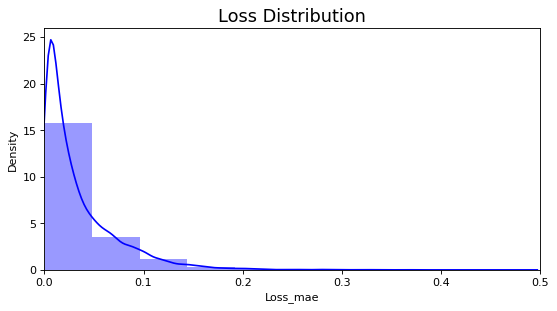

In [140]:
####Test data

test_data=pd.read_csv('/content/sample_data/cumminstrainingdata.csv')
test_data=test_data['description'].to_list()

sentences=test_data
tokenizer = Tokenizer(num_words = vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)
# reshape inputs for LSTM [samples, timesteps, features]
X_test=padded
X_test = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test_pred = model.predict(X_test)
X_test_pred = X_test_pred.reshape(X_test_pred.shape[0], X_test_pred.shape[1])
X_test_pred = pd.DataFrame(X_test_pred)

scored = pd.DataFrame(index=X_test_pred.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[1])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Automatable']=scored[scored['Loss_mae'] >0.15]
plt.figure(figsize=(8,4), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 10, kde= True, color = 'blue');
plt.xlim([0.0,.5])